In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, random,sys, json,zipfile, time
from copy import deepcopy
import plotly.graph_objects as go
import math
from scipy.stats import spearmanr
import plotly.express as px
from scipy.optimize import minimize
from copy import deepcopy
import plotly.express as px
from scipy.stats import gaussian_kde
import collections,random
from scipy.spatial import distance
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
#------------ Functions for prepocessing -----------------#
def convert_values_tol_log_scale(df_data):
  # lista_log = ['var', 'iqr', 'idr', 'min', 'mean', 'skew', 'kurt', 'mean_cubic','range','cycles']
  lista_log = ['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10', 'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10', 'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10','cycles']
  for el in lista_log:
    if (df_data[el]<0).any():
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(abs(x)))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(abs(x)))
    else:
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(x))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(x))
  return df_data
def convert_from_log_to_normal(actual,preds):
  pred_actual =  np.round(10**preds,decimals=0)
  values_actual = np.round(10**actual,decimals=0)
  return values_actual,pred_actual
# ------------------------------------ WSMOTE algorithms --------------------------#
def apply_denseweight(Y): # ΣΑΝ ΝΑ ΚΑΝΕΙΣ LABEL FOR IMBALANCED DATA DEMSITY ESTIMATION
  """
    Compute rarity weights based on kernel density estimation (KDE).
  """
  kde = gaussian_kde(Y) # This is occured for all the variable
  density = kde(Y)
  rarity = 1/density
  weights = rarity/rarity.sum()
  weights_with_targets = [[inda,int(y),float(w)] for inda,(y,w) in enumerate(zip(Y,weights))]
  return weights_with_targets

def find_k_neighbours_from_the_target_values(X,Y,K_SHFT,selected_index,med_val,mixed_list,sorted_mixed_list):
  """
    Find the second seed for the SMOTER algorithm based on the K parameter
  """
  until_value, second_seed_index =0, -1000
  # for tracking reason is more prefereable to sort the weights, index, taget value list
  X_first_seed,Y_first_seed = X[selected_index],Y[selected_index] #
  sorted_first_seed_index = next((i for i, x in enumerate(sorted_mixed_list) if x[0] == selected_index), None)
  if med_val>=Y_first_seed:
    until_value = sorted_first_seed_index + K_SHFT+1
    selected_target_neighbors = sorted_mixed_list[sorted_first_seed_index+1:until_value] # go rightwards
  elif med_val< Y_first_seed:
    until_value = sorted_first_seed_index-(K_SHFT+1)
    selected_target_neighbors = sorted_mixed_list[sorted_first_seed_index-1:until_value:-1] # go leftwards
  random_neighbor_index = np.random.choice(len(selected_target_neighbors))
  second_instance_sorted = selected_target_neighbors[random_neighbor_index]
  return X[second_instance_sorted[0]],second_instance_sorted[1]

def cosine_similarity(a, b):
    """
      Computes cosine similarity
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)
def generate_synthetic_samples(feature1,feature2,y1,y2,median_value,inv_cov):
  '''
  Function that generates synthetic data based on the Smote Regression Logic!
  Uses cosine similairy due to the dimensionality curse!
  '''
  lambda_variable = round(random.random(),4)
  gen_point = feature1 + lambda_variable*(feature2-feature1)
  # Apply euclidean distance to ensure that tha
  # distance_1,distance_2 = np.linalg.norm(gen_point - feature1)/np.sqrt(len(feature1)),np.linalg.norm(gen_point - feature2)/np.sqrt(len(feature2)) # euclidean distance does not work well due to curse of dimensionality
  # print(distance_1,distance_2)
  #------------------------- distance mahalombis-------------------------------------#
  # print(gen_point.shape,feature1.shape,feature2.shape,inv_cov1.shape,inv_cov2.shape,np.cov(np.vstack([feature1, gen_point])).shape,np.vstack([feature1, gen_point].shape))
  # sys.exit()
  # print(np.linalg.inv(np.cov(np.vstack([feature1, gen_point]), rowvar=False)).shape,np.linalg.inv(np.cov(np.vstack([feature2, gen_point]), rowvar=False)).shape)
  # inv_cov1,inv_cov2 = np.linalg.inv(np.cov(np.vstack([feature1, gen_point]), rowvar=False)),np.linalg.inv(np.cov(np.vstack([feature2, gen_point]), rowvar=False))
  # distance_1,distance_2 = distance.mahalanobis(gen_point, feature1, inv_cov1),distance.mahalanobis(gen_point, feature2, inv_cov2)
  # print(distance_1,distance_2)
  # weight_1,weight_2 = 1/distance_1,1/distance_2
  #----- cosine similarity
  cos_weight_1,cos_weight_2 = cosine_similarity(gen_point, feature1),cosine_similarity(gen_point, feature2)
  weight_1,weight_2 = cos_weight_1 /( cos_weight_1+cos_weight_2),cos_weight_2 /( cos_weight_1+cos_weight_2) # Normalize cosine
  generated_y = int(weight_1*y1 + weight_2*y2)
  return gen_point,generated_y

def apply_WS_smoter(X_init,Y_init, N,K,median_value):
  '''
  Function which applies WS_Smoter.
  '''
  X_resampled,Y_resampled = X_init,Y_init
  below_median_generated_points,above_median_generated_points = [],[]
  dense_weights = apply_denseweight(Y=Y_init) # out of the for loop
  sorted_dense_weights = sorted(dense_weights, key=lambda x: x[1]) # because that how i will select the neighbors
  weights = [w for i,y,w in dense_weights]

  while (len(below_median_generated_points)<N or len(above_median_generated_points)<N):
    select_first_seed_index = np.random.choice(len(X_init),p= weights)
    X_first_seed,Y_first_seed = X_init[select_first_seed_index],Y_init[select_first_seed_index]
    # NSURE THAT DATA POINT ARE EQUALLY REPRESENTED ABOVE AND BELOW THE MEDIAN
    if len(below_median_generated_points)==N and Y_first_seed<median_value :
      while Y_first_seed<median_value:
        select_first_seed_index = np.random.choice(len(X_init),p= weights,replace=True)
        X_first_seed,Y_first_seed = X_init[select_first_seed_index],Y_init[select_first_seed_index]

      # take value above the median so we ensure the balance
    if len(above_median_generated_points) == N and Y_first_seed>median_value:
      while Y_first_seed>median_value:
        select_first_seed_index = np.random.choice(len(X_init),p= weights,replace=True)# do it with replacement and allow repeats.
        X_first_seed,Y_first_seed = X_init[select_first_seed_index],Y_init[select_first_seed_index]
    if Y_first_seed>median_value:
      above_median_generated_points.append(Y_first_seed)
    else:
      below_median_generated_points.append(Y_first_seed)

    X_second_seed,Y_second_seed = find_k_neighbours_from_the_target_values(X=X_init,Y=Y_init,K_SHFT=K,
                                            selected_index=select_first_seed_index,
                                            med_val=median_value,
                                            mixed_list=dense_weights,
                                            sorted_mixed_list=sorted_dense_weights)
    X_gen_seed,Y_gen_seed = generate_synthetic_samples(feature1 =X_first_seed,feature2 =X_second_seed,
                                                      y1= Y_first_seed,y2= Y_second_seed,
                                                      median_value=median_value,
                                                      inv_cov= np.linalg.inv(np.cov(X_init)))

    X_resampled, Y_resampled= np.append(X_resampled, np.array([X_gen_seed]),axis=0),np.append(Y_resampled,np.array([Y_gen_seed]),axis=0)

  return X_resampled,Y_resampled


In [7]:
WANTED_CYCLE = 100
init_df = pd.read_csv(f'/content/drive/MyDrive/battery_degradation/f_data_{WANTED_CYCLE}_10.csv')
init_df.drop(columns = {'Unnamed: 0'},inplace=True)
init_df.columns

Index(['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10',
       'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10',
       'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10',
       'average_charge_2_6', 'average_charge_2_WI', 'min_resistance_2_100',
       'diff_resistance_2_100', 'temperature_integral', 'discharge_cycle_2',
       'discharge_cycle_WI', 'slope_2_100', 'intercept_2_100', 'cycles',
       'diff_disc_cap_2_max'],
      dtype='object')

In [8]:
var_ar =  init_df['var_DQ_100_10'].values
cmap1 = plt.get_cmap('coolwarm')
cycles_ar = init_df['cycles'].values

colors_2_c = [cmap1(1-(x - min(cycles_ar)) / (max(cycles_ar) - min(cycles_ar))) for x in cycles_ar]
plotly_colors = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c]

fig_2c_ex = go.Figure()
fig_2c_ex.add_trace(go.Scatter(x=var_ar,
                          y=cycles_ar,

  mode='markers',marker=dict(size=22,color=plotly_colors,
            opacity=1, )))
fig_2c_ex.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_ex.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale = np.array([np.log10(c_l) for c_l in cycles_ar])
var_ar_log_scale = np.array([np.log10(va) for va in var_ar])
pear_2C = np.corrcoef(var_ar_log_scale,cycle_ar_log_scale)[0,1]
print(f" The pearson correlation is {pear_2C}")

 The pearson correlation is -0.9159176982572148


In [10]:
import sys
K= 10 # The look up ellement after the initialization of the first seed
X_init,Y_init= init_df.drop(columns = "cycles").values , init_df['cycles'].values

median_value = init_df['cycles'].median()
x_resampled,Y_resampled = apply_WS_smoter(X_init=X_init,Y_init=Y_init, N=math.ceil(len(X_init)/2),K=K,median_value=median_value) # Nexpresse the oversampling percentage where here we choose to double our datsaet


In [11]:
var_ar_res =  x_resampled[:, 0]
colors_2_c_res = [cmap1(1-(x - min(Y_resampled)) / (max(Y_resampled) - min(Y_resampled))) for x in Y_resampled]
plotly_colors_res = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c_res]

fig_2c_ex = go.Figure()
fig_2c_ex.add_trace(go.Scatter(x=var_ar_res,
                          y=Y_resampled,

  mode='markers',marker=dict(size=22,color=plotly_colors_res,
            opacity=1, )))
fig_2c_ex.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_ex.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale_res = np.array([np.log10(c_l) for c_l in Y_resampled])
var_ar_log_scale_res = np.array([np.log10(va) for va in var_ar_res])
pear_2C_res = np.corrcoef(var_ar_log_scale_res,cycle_ar_log_scale_res)[0,1]
print(f" The pearson correlation is {pear_2C_res }")

 The pearson correlation is -0.93704438892299


# Histogram initial vs final

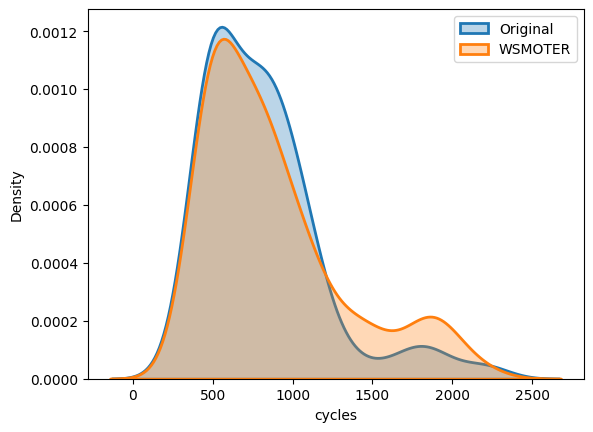

In [12]:
sns.kdeplot(init_df['cycles'], label = "Original", fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(Y_resampled, label = "WSMOTER", fill=True, alpha=0.3, linewidth=2)

plt.legend(loc='upper right')  # Move legend to upper right corner
plt.show()

**No you need to implement the models elastic net and using grid search and or randoma forest.**

In [ ]:
# Create the train test for the training
from sklearn.model_selection import train_test_split

K= 10 # The look up ellement after the initialization of the first seed


X_init_copy_df = init_df.drop(columns = ["cycles",'discharge_cycle_WI','average_charge_2_WI'])
# print(X_init_copy_df.columns)
X_init_copy = X_init_copy_df.values

Y_init_copy = init_df['cycles'].values
median_value = np.median(Y_init_copy)

x_train_init,x_test,ytrain_init,y_test = train_test_split(X_init_copy,Y_init_copy,
                                                          test_size=0.3,random_state=0 )

median_value_train =np.median(ytrain_init)
print(median_value_train)

x_resampled_train_1,Y_resampled_train_1 = apply_WS_smoter(X_init=x_train_init,Y_init=ytrain_init, N=math.ceil(len(x_train_init)/2),K=K,median_value=median_value_train)
wanted_columns = X_init_copy_df.columns.tolist()
x_df = pd.DataFrame(x_resampled_train_1, columns=wanted_columns)
y_df = pd.DataFrame(Y_resampled_train_1, columns=['cycles'])
pro_logscale_df = pd.concat([x_df, y_df], axis=1)
pro_logscale_df = convert_values_tol_log_scale(df_data = pro_logscale_df.copy())
x_resampled_train,Y_resampled_train =pro_logscale_df.drop(columns=['cycles']),pro_logscale_df['cycles']

In [ ]:
len(x_resampled_train_1[5])

19

In [ ]:
# Define parameter grids
parameter_elastic_net = {
    'alpha': [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0],
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.78, 0.8, 0.82, 0.85, 0.86, 0.9]
}

# GridSearchCV for both models
grid_search_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=5000),
    param_grid=parameter_elastic_net,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0)


grid_search_elastic.fit(x_resampled_train,Y_resampled_train)


# Best estimators
best_model_ELA = grid_search_elastic.best_estimator_

# Predict on test set
preds_test_ELA = best_model_ELA.predict(x_test)

# Convert back from log scale
actual_test, pred_test_ela = convert_from_log_to_normal(y_test, preds_test_ELA)

# Compute metrics
mae_ela = mean_absolute_error(actual_test, pred_test_ela)
rmse_ela =  np.sqrt(mean_squared_error(actual_test, pred_test_ela))


# Create individual DataFrames
elastic_df = pd.DataFrame({
    'Model': ['ElasticNet'],
    'MAE': [mae_ela],
    'RMSE': [rmse_ela],
    'Best Parameters': [grid_search_elastic.best_params_]
})


# Display results
print("📊 ElasticNet Results:")
print(elastic_df, "\n")

📊 ElasticNet Results:
        Model         MAE        RMSE                     Best Parameters
0  ElasticNet  101.297297  106.304763  {'alpha': 1e-06, 'l1_ratio': 0.01} 



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e-01, tolerance: 7.270e-04

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



In [ ]:
parameters_random_forests = {
    'n_estimators': [1, 3, 5, 10, 30, 50, 100, 1000],
    'criterion': ['absolute_error'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5]
}
grid_search_forest = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=parameters_random_forests,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0
)

grid_search_forest.fit(x_resampled_train,Y_resampled_train)
best_model_FOREST = grid_search_forest.best_estimator_
preds_test_FOREST = best_model_FOREST.predict(x_test)

actual_test, pred_test_forest = convert_from_log_to_normal(y_test, preds_test_FOREST)


mae_forest = mean_absolute_error(actual_test, pred_test_forest)
rmse_forest = np.sqrt( mean_squared_error(actual_test, pred_test_forest))


forest_df = pd.DataFrame({
    'Model': ['RandomForest'],
    'MAE': [mae_forest],
    'RMSE': [rmse_forest],
    'Best Parameters': [grid_search_forest.best_params_]
})
print("🌲 RandomForest Results:")
print(forest_df)

🌲 RandomForest Results:
          Model         MAE        RMSE  \
0  RandomForest  516.216216  521.358983   

                                     Best Parameters  
0  {'criterion': 'absolute_error', 'max_depth': N...  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

